# CMPE 255 - Project - Raasin Siddiq

Data info:
<br>
This data set consists of positions and absorbed power outputs of wave energy converters (WECs) in four real wave scenarios from the southern coast of Australia.
<br>
<br>
Additional Information
<br>
This data set consists of positions and absorbed power outputs of wave energy converters (WECs) in four real wave scenarios from the southern coast of Australia (Sydney, Adelaide, Perth and Tasmania). The applied converter model is a fully submerged three-tether converter called CETO [1]. 16 WECs locations are placed and optimized in a size-constrained environment. In terms of optimization, the problem is categorised as an expensive optimization problem that each farm evaluation takes several minutes. The results are derived from several popular and successful Evolutionary optimization methods that are published in [2,3].  The source code of the applied hydrodynamic simulator [4] is available by the below link: 
https://au.mathworks.com/matlabcentral/fileexchange/71840-wave-energy-converter-wec-array-simulator
<br>
This work was supported with supercomputing resources provided by the Phoenix HPC service at the University of Adelaide.
<br>
<br>
Attribute: Attribute Range 
1. WECs position {X1, X2, â€¦, X16; Y1, Y2,â€¦, Y16} continuous from 0 to 566 (m). 
2. WECs absorbed power: {P1, P2, â€¦, P16} 
3. Total power output of the farm: Powerall
<br>
<br>
- https://archive.ics.uci.edu/dataset/494/wave+energy+converters
- https://archive.ics.uci.edu/dataset/882/large-scale+wave+energy+farm


## Imports

In [143]:
# Imports
import numpy as np
import scipy as sp
import scipy.sparse as sps
import sklearn
import pandas as pd
import math, glob, csv

%matplotlib inline
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.sparse import csr_matrix, csr_array
from sklearn import linear_model 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

In [71]:
import tensorflow as tf

## Load Data

In [73]:
# Open and read train file
data_path  = "wecs_data/"
data_paths = glob.glob(data_path+"*.csv")
print(data_paths)

['wecs_data/Adelaide_Data.csv', 'wecs_data/Perth_Data.csv', 'wecs_data/Sydney_Data.csv', 'wecs_data/Tasmania_Data.csv']


In [27]:
data_ade = np.genfromtxt(fname=data_paths[0], dtype=np.float64, delimiter=',')
data_per = np.genfromtxt(fname=data_paths[1], dtype=np.float64, delimiter=',')
data_syd = np.genfromtxt(fname=data_paths[2], dtype=np.float64, delimiter=',')
data_tas = np.genfromtxt(fname=data_paths[3], dtype=np.float64, delimiter=',')

print(f"Adelaide data: {data_ade.shape}")
print(f"Perth    data: {data_per.shape}")
print(f"Sydney   data: {data_syd.shape}")
print(f"Tasmania data: {data_tas.shape}")

Adelaide data: (71999, 49)
Perth    data: (72000, 49)
Sydney   data: (72000, 49)
Tasmania data: (72000, 49)


In [100]:
labels_text = ["Adelaide","Perth","Sydney","Tasmania"]
data_ade_labels = np.hstack((data_ade, np.full((data_ade.shape[0], 1), 0)))
data_per_labels = np.hstack((data_per, np.full((data_per.shape[0], 1), 1)))
data_syd_labels = np.hstack((data_syd, np.full((data_syd.shape[0], 1), 2)))
data_tas_labels = np.hstack((data_tas, np.full((data_tas.shape[0], 1), 3)))

In [101]:
# data_all        = np.vstack((data_ade,data_per,data_syd,data_tas))
data_all_labels = np.vstack((data_ade_labels,data_per_labels,data_syd_labels,data_tas_labels))

# print(f"All data: {data_all.shape}")
print(f"All data with labels: {data_all_labels.shape}")

All data with labels: (287999, 50)


In [102]:
print(data_all_labels[:,:-1])
print()
print(data_all_labels[:,-1])

[[3.16585500e+02 2.23927700e+02 1.82343400e+02 ... 9.84472846e+04
  9.75702225e+04 1.37037415e+06]
 [5.30313600e+02 6.87031000e+01 3.15983000e+01 ... 7.82344337e+04
  8.46336493e+04 1.34092976e+06]
 [2.73967000e+01 3.99048800e+02 5.65685400e+02 ... 8.30309726e+04
  9.47796131e+04 1.35203151e+06]
 ...
 [4.97652000e+01 9.04154000e+01 1.10600000e+02 ... 2.36459006e+05
  2.22454797e+05 3.71833084e+06]
 [5.39431400e+02 1.54626200e+02 4.93822500e+02 ... 2.67671188e+05
  2.49700455e+05 3.68547554e+06]
 [5.65685400e+02 9.80576000e+01 4.37254000e+02 ... 2.65369246e+05
  2.40729017e+05 3.73328110e+06]]

[0. 0. 0. ... 3. 3. 3.]


## Preprocessing

In [150]:
def LR(X, Y, v1="A", v2="B"):
    X = X.reshape(-1, 1)
    Y = Y.reshape(-1, 1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    slope = regr.coef_[0][0]
    intercept = regr.intercept_[0]

    # print("%s = %f + %fx%s" %(v2, intercept, slope, v1))
    sse = np.sum((regr.predict(X) - Y) ** 2)
    # print("Sum of squared errors: %f" % sse)
    # Explained variance score: 1 is perfect prediction
    # print('Variance score: %f' % regr.score(X, Y))
    return slope, intercept, sse, v1, v2

In [160]:
data_all.shape[1]

49

In [167]:
lowest_sse = 10000000000000000000000000
lowest_v1  = 10000000000000000000000000
lowest_v2  = 10000000000000000000000000

for i in range(data_all.shape[1]):
    for j in range(data_all.shape[1]):
        if i != j:
            _, _, sse, v1, v2 = LR(data_all[:,i], data_all[:,j])
            # print(sse)
            if sse <= lowest_sse:
                lowest_sse = sse
                lowest_v1 = i+1
                lowest_v2 = j+1
                print(lowest_sse, lowest_v1, lowest_v2)

print()
print(lowest_sse, lowest_v1, lowest_v2)

9967238836.547249 1 2
9720160880.776854 1 5
9512231506.38359 1 8
9128760649.374132 1 18
8784266477.657103 2 18

8784266477.657103 2 18


In [ ]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data_all_labels[:,:-1],
    data_all_labels[:,-1],
    train_size=0.80,
    random_state=1,
    stratify=data_all_labels[:,-1])

## Neural Network

In [179]:
tf.random.set_seed(1)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(49, activation='relu'),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Dense(1)
])

In [180]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.binary_crossentropy,
              metrics=["accuracy"])

In [181]:
history = model.fit(train_data, train_labels, epochs=100)

Epoch 1/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 7s 691us/step - accuracy: 0.2499 - loss: 24.1868
Epoch 2/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 5s 689us/step - accuracy: 0.2499 - loss: 24.1868
Epoch 3/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 5s 697us/step - accuracy: 0.2499 - loss: 24.1868
Epoch 4/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 5s 688us/step - accuracy: 0.2499 - loss: 24.1868
Epoch 5/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 5s 683us/step - accuracy: 0.2499 - loss: 24.1868
Epoch 6/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 5s 683us/step - accuracy: 0.2499 - loss: 24.1868
Epoch 7/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 5s 681us/step - accuracy: 0.2499 - loss: 24.1868
Epoch 8/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 5s 691us/step - accuracy: 0.2499 - loss: 24.1868
Epoch 9/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 5s 695us/step - accuracy: 0.2499 - loss: 24.1868
Epoch 10/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 5s 691us/step - accuracy: 0.2499 - loss: 24.1868
Epoch 11/100
7200/7200 ━━━━━━━━━━━━━━━━━━━━ 5s 686us/step - accuracy: 0.2499 - 

KeyboardInterrupt: 

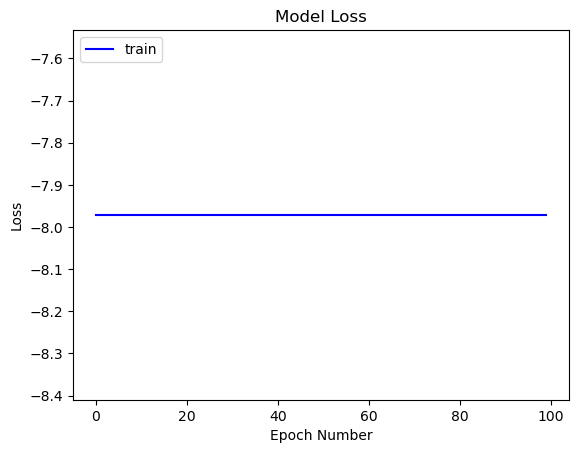

In [182]:
plt.plot(history.history['loss'], color='b')
# plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch Number')
plt.legend(['train'], loc='upper left')
# plt.legend(['train', 'val'], loc='upper left')
plt.show()

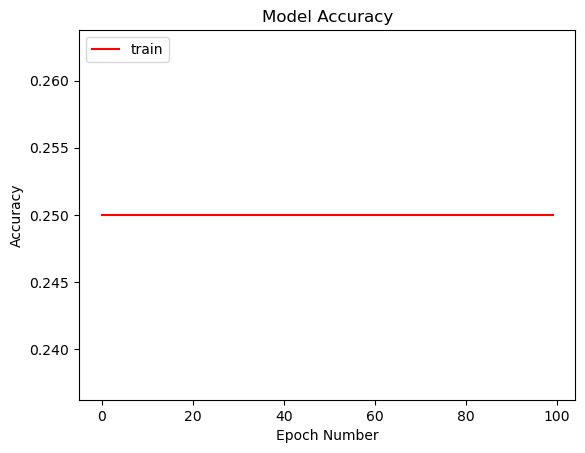

In [183]:
plt.plot(history.history['accuracy'], color='r')
# plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch Number')
plt.legend(['train'], loc='upper left')
# plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [184]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

1800/1800 - 1s - 523us/step - accuracy: 0.2500 - loss: 24.1771


In [185]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_acc}")

Test Loss:     24.177146911621094
Test Accuracy: 0.25


## Predictions

In [186]:
probability_model = tf.keras.Sequential([model,
                                         tf.keras.layers.Softmax()])

In [187]:
predictions = probability_model.predict(test_data)

 294/1800 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step

/opt/conda/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


1800/1800 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step


In [188]:
predictions[0]

array([0.99999994], dtype=float32)

In [189]:
np.argmax(predictions[0])

0

## Decision Tree

In [190]:
train_data, test_data, train_labels, test_labels

(array([[4.20224400e+02, 0.00000000e+00, 8.65464000e+01, ...,
         9.82302577e+04, 9.04281811e+04, 1.47891072e+06],
        [0.00000000e+00, 5.59752000e+02, 5.44896100e+02, ...,
         1.03462291e+05, 8.78677009e+04, 1.51470855e+06],
        [4.62668800e+02, 5.36491700e+02, 4.20732000e+01, ...,
         9.00328778e+04, 1.04727851e+05, 1.51075548e+06],
        ...,
        [5.17341200e+02, 3.78373700e+02, 5.64688500e+02, ...,
         7.78694825e+04, 8.77623067e+04, 1.40113602e+06],
        [5.65685400e+02, 1.03266300e+02, 1.33910000e+02, ...,
         9.70211491e+04, 7.23333474e+04, 1.37055476e+06],
        [1.70670500e+02, 8.34370000e+00, 2.03436700e+02, ...,
         1.05666393e+05, 8.28172400e+04, 1.45547597e+06]]),
 array([[5.09886000e+02, 4.71139000e+01, 1.47400400e+02, ...,
         2.65512574e+05, 2.37807846e+05, 3.75696094e+06],
        [5.66000000e+02, 2.59847000e+02, 2.10538600e+02, ...,
         9.67840914e+04, 8.38149322e+04, 1.38404862e+06],
        [4.11265000e+02, 

In [191]:
dtc = DecisionTreeClassifier()
dtc.fit(train_data, train_labels)

DecisionTreeClassifier()

In [ ]:
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(dtc, 
                   # feature_names=feature_names,  
                   class_names=labels_text,
                   filled=True)

In [192]:
dtc.score(test_data, test_labels)

0.8856597222222222

In [193]:
scores = cross_val_score(dtc, train_data, train_labels, cv=11)
print(f"Cross Val Score = {np.mean(scores)}")

Cross Val Score = 0.8841965446498921


In [194]:
predictions = dtc.predict(test_data)
f1 = sklearn.metrics.f1_score(
    y_true=test_labels,
    y_pred=predictions,
    average='weighted')
print(f"F1 Score = {f1}")

F1 Score = 0.8855902752903452


In [198]:
test_dtc_predictions = dtc.predict(test_data)

In [199]:
print(f"Length of test predictions: {test_dtc_predictions.shape}")
print(test_dtc_predictions[:12])

Length of test predictions: (57600,)
[3. 1. 1. 2. 2. 3. 0. 1. 3. 2. 0. 3.]


In [200]:
test_labels[:12]

array([3., 1., 1., 2., 2., 3., 0., 1., 3., 2., 0., 3.])

In [207]:
np.unique(test_dtc_predictions == test_labels,return_counts=True)

(array([False,  True]), array([ 6586, 51014]))

In [209]:
51014/(51014+6586)

0.8856597222222222